### Load data

In [1]:
import numpy as np
import pandas as pd
import math
import random
import GPy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Hide some warnings
pd.options.mode.chained_assignment = None 

In [2]:
# Load four sheets from excel file

denver = pd.read_excel('Datas.xls', sheet_name='DEN')
newyork = pd.read_excel('Datas.xls', sheet_name='NYC')
sanfrancisco = pd.read_excel('Datas.xls', sheet_name='SFC')
texas = pd.read_excel('Datas.xls', sheet_name='TXS')

# Set random seed
random.seed(48)

In [3]:
# Cleen data to make it easier to handle

denver['station'] = denver['station'].replace(np.nan,'DENVER INTL AP')
denver['station'] = denver['station'].replace('DENVER INTL AP', 'DEN')
newyork['station'] = newyork['station'].replace(np.nan, 'JFK')
sfc = sanfrancisco.drop(columns = 'valid', axis=1)

In [4]:
#Function to rename columns 

def rename_columns(df, col_names):
    cols = df.columns
    for col, new_col in zip(cols, col_names):
        df.rename(columns={col:new_col}, inplace=True)

In [5]:
# Rename columns in all datasets to same column names

col_names = ['station', 'skycloud', 'day', 'tmpf', 'feel', 
             'zenith', 'azimuth', 'glob', 'direct', 
             'diffused', 'albedo', 'time', 'power']

rename_columns(denver, col_names)
rename_columns(newyork, col_names)
rename_columns(sfc, col_names)
rename_columns(texas, col_names)

In [6]:
# Join all 4 datasets into a single dataframe

frames = [denver, newyork, sfc, texas]
data = pd.concat(frames)


# Create dataset for denver station
den = data.loc[data['station'] == 'DEN']

### Feature selection
For more detail on feature selection, see notebook 'GPR_article_recreation' 

In [7]:
# Drop columns with low correlation

den = den.drop(columns = ['skycloud', 'feel', 'albedo'], axis=1)

In [8]:
# Drop rows with azimuth = -99 values

den.drop(den.index[den['azimuth'] == -99], inplace = True)

### Scaler and train test split

In [9]:
# Create X and y values

X_val = den.drop(columns = ['station', 'day', 'time', 'power'], axis=1)
X = X_val.values
y = den.power.values

In [33]:
# Train test split and scale data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=48, shuffle=False)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

scaler = MinMaxScaler()
X_tr_sc = scaler.fit_transform(X_train)
X_te_sc = scaler.transform(X_test)
y_tr_sc = scaler.fit_transform(y_train)
y_te_sc = scaler.transform(y_test)

In [27]:
# Create length scale and length scale bounds

feature_len = len(X_tr_sc[0])
len_scale = np.ones(feature_len)

hp_low = 1e-10
hp_high = 100000

hp_bounds = np.zeros(shape = (feature_len,2))
hp_bounds[:,0] = hp_low
hp_bounds[:,1] = hp_high

### GPy model

In [12]:
# Gpy model matern 52 kernel

kernel = GPy.kern.Matern52(ARD=True, input_dim=feature_len, lengthscale=len_scale)
model = GPy.models.GPRegression(X_tr_sc, y_tr_sc, kernel) 

In [13]:
# Predict values

mean, variance = model.predict(X_te_sc)

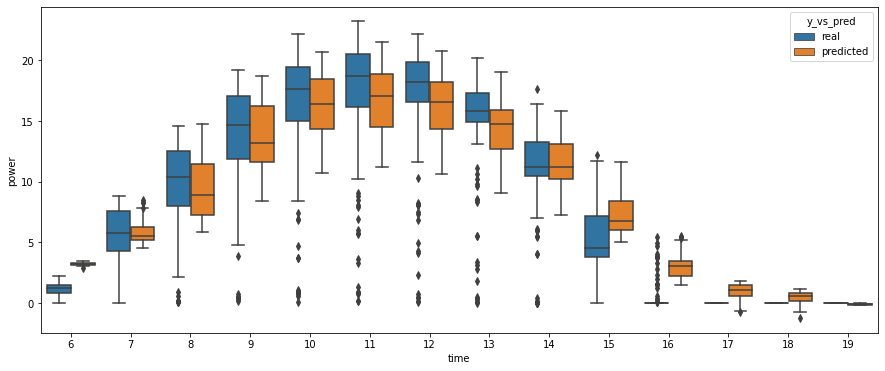

In [14]:
# Scale back values and plot boxplot of predicted vs real values

d_new = den[len(X_train):]
mean_actual = scaler.inverse_transform(mean)

lst1 = ['real'] * len(X_test)
lst2 = ['predicted'] * len(X_test)

test_df1 = d_new.copy()
test_df1['y_vs_pred'] = lst1

test_df2 = d_new.copy()
test_df2.drop('power', inplace=True, axis=1)

test_df2['y_vs_pred'] = lst2
test_df2['power'] = mean_actual

frames_ = [test_df1, test_df2]
test_df = pd.concat(frames_)

fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax = sns.boxplot(x="time", y="power", hue="y_vs_pred", data=test_df)

### Sklearn GPR model

In [34]:
# sklearn gpr model matern 52 kernel + white kernel

kernel = Matern(length_scale=len_scale, length_scale_bounds=hp_bounds, nu=2.5) + WhiteKernel(noise_level=0.1)
model2 = GaussianProcessRegressor(kernel=kernel)
model2.fit(X_tr_sc, y_tr_sc)

GaussianProcessRegressor(kernel=Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.1))

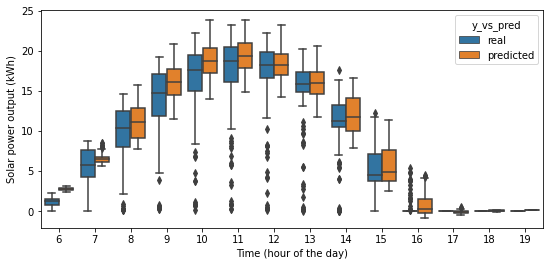

In [36]:
pred_val = model2.predict(X_te_sc)
pred_val_new = scaler.inverse_transform(pred_val)

lst1 = ['real'] * len(X_test)
lst2 = ['predicted'] * len(X_test)

test_df1 = d_new.copy()
test_df1['y_vs_pred'] = lst1

test_df2 = d_new.copy()
test_df2.drop('power', inplace=True, axis=1)

test_df2['y_vs_pred'] = lst2
test_df2['power'] = pred_val_new

frames_ = [test_df1, test_df2]
test_df = pd.concat(frames_)

fig, ax = plt.subplots(1,1, figsize=(9, 4))
ax = sns.boxplot(x="time", y="power", hue="y_vs_pred", data=test_df)
ax.set_xlabel('Time (hour of the day)')
ax.set_ylabel('Solar power output (kWh)')

plt.show()

In [37]:
mae = mean_absolute_error(y_te_sc, pred_val)
mse = mean_squared_error(y_te_sc, pred_val)
rmse = math.sqrt(mse)

print('MAE (%): ', mae*100)
print('RMSE (%): ', rmse*100)

MAE (%):  8.899767580667667
RMSE (%):  16.983569960803347
